In [1]:
# Importing necessary libraries

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', False)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("cubehelix") # Other palettes: "Set2", "husl", "cubehelix", "hls"

In [2]:
# Reading the input file

import os
cwd = os.getcwd()

train_values = cwd + "\\Source Data\\train_values.csv"
train_values = pd.read_csv(train_values)
train_labels = cwd + "\\Source Data\\train_labels.csv"
train_labels = pd.read_csv(train_labels)

test_values = cwd + "\\Source Data\\test_values.csv"
test_values = pd.read_csv(test_values)
test_id = test_values.patient_id
test = test_values.drop('patient_id', axis=1)

train = train_values.join(train_labels.set_index('patient_id'), on='patient_id', how='left')

In [3]:
# Data Prep

re_categorize_values = {"chest_pain_type": {1: "one", 2: "two", 3: "three", 4: "four"},
                       "fasting_blood_sugar_gt_120_mg_per_dl": {0: "Less than 120", 1: "Greater than 120"},
                       "resting_ekg_results": {1: "one", 2: "two", 0: "zero"},
                       "sex": {0: "female", 1: "male"},
                       "exercise_induced_angina": {0: "No", 1: "Yes"}}

train.replace(re_categorize_values, inplace=True)
test.replace(re_categorize_values, inplace=True)

y = train['heart_disease_present']
x = train.drop(['heart_disease_present', 'patient_id'], axis=1)

In [4]:
# Looking for missing or null values

x.isna().sum()

slope_of_peak_exercise_st_segment       0
thal                                    0
resting_blood_pressure                  0
chest_pain_type                         0
num_major_vessels                       0
fasting_blood_sugar_gt_120_mg_per_dl    0
resting_ekg_results                     0
serum_cholesterol_mg_per_dl             0
oldpeak_eq_st_depression                0
sex                                     0
age                                     0
max_heart_rate_achieved                 0
exercise_induced_angina                 0
dtype: int64

From the information above, we do not see any missing values in the train data set

In [5]:
test.isna().sum()

slope_of_peak_exercise_st_segment       0
thal                                    0
resting_blood_pressure                  0
chest_pain_type                         0
num_major_vessels                       0
fasting_blood_sugar_gt_120_mg_per_dl    0
resting_ekg_results                     0
serum_cholesterol_mg_per_dl             0
oldpeak_eq_st_depression                0
sex                                     0
age                                     0
max_heart_rate_achieved                 0
exercise_induced_angina                 0
dtype: int64

There are no missing values for the test data set as well

In [6]:
x.dtypes

slope_of_peak_exercise_st_segment         int64
thal                                     object
resting_blood_pressure                    int64
chest_pain_type                          object
num_major_vessels                         int64
fasting_blood_sugar_gt_120_mg_per_dl     object
resting_ekg_results                      object
serum_cholesterol_mg_per_dl               int64
oldpeak_eq_st_depression                float64
sex                                      object
age                                       int64
max_heart_rate_achieved                   int64
exercise_induced_angina                  object
dtype: object

In [7]:
# Select the columns to include

cols_to_include = list(x.columns)
#cols_to_include.remove('thal')

x = x[cols_to_include]
test = test[cols_to_include] 

In [8]:
# Generating dummies

x_rows = x.shape[0]
df = x.append(test)

df = pd.get_dummies(df, drop_first=True)

x = df.iloc[:x_rows,]
test = df.iloc[x_rows:,]


In [9]:
# Performing the Train Test Split

from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x,y, 
                                                                stratify=y, 
                                                                random_state=1, 
                                                                test_size=0.25)

Confustion Matrix for Training Data - Logistic Regression
[[69  6]
 [ 9 51]]
Confustion Matrix for Test Data - Logistic Regression
[[20  5]
 [ 4 16]]
Classification Report for Training Data - Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        75
           1       0.89      0.85      0.87        60

   micro avg       0.89      0.89      0.89       135
   macro avg       0.89      0.89      0.89       135
weighted avg       0.89      0.89      0.89       135

Classification Report for Test Data - Logistic Regression
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        25
           1       0.76      0.80      0.78        20

   micro avg       0.80      0.80      0.80        45
   macro avg       0.80      0.80      0.80        45
weighted avg       0.80      0.80      0.80        45

Log loss for Training data:  0.30116677970896105
Log loss for Validation dat

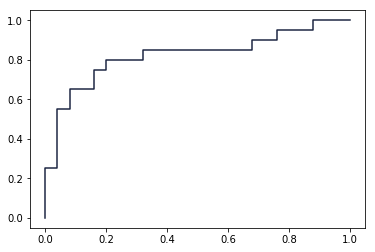

In [10]:
# Running a simple logistic regression classifier using all the columns

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(x_train, y_train)
train_predictions = model.predict(x_train)
predictions = model.predict(x_validation)

# Accuracy Metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Confusion Matrix Comparison
print("Confustion Matrix for Training Data - Logistic Regression")
print(confusion_matrix(y_train, train_predictions))
print("Confustion Matrix for Test Data - Logistic Regression")
print(confusion_matrix(y_validation, predictions))

# Classification Report Comparison
print("Classification Report for Training Data - Logistic Regression")
print(classification_report(y_train, train_predictions))
print("Classification Report for Test Data - Logistic Regression")
print(classification_report(y_validation, predictions))

proba_train_predictions = model.predict_proba(x_train)[:,1]
proba_predictions = model.predict_proba(x_validation)[:,1]
roc_auc_score(y_validation, proba_predictions, average='weighted')

# Print the log loss metric

print("Log loss for Training data: ", log_loss(y_train, proba_train_predictions))
print("Log loss for Validation data: ", log_loss(y_validation, proba_predictions))

fpr, tpr, threshold = roc_curve(y_validation, proba_predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("\nAUROC Plot from Logistic Regression:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

Confustion Matrix for Training Data - Logistic Regression
[[66  9]
 [ 8 52]]
Confustion Matrix for Test Data - Logistic Regression
[[15 10]
 [ 4 16]]
Classification Report for Training Data - Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.88      0.89        75
           1       0.85      0.87      0.86        60

   micro avg       0.87      0.87      0.87       135
   macro avg       0.87      0.87      0.87       135
weighted avg       0.87      0.87      0.87       135

Classification Report for Test Data - Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.60      0.68        25
           1       0.62      0.80      0.70        20

   micro avg       0.69      0.69      0.69        45
   macro avg       0.70      0.70      0.69        45
weighted avg       0.71      0.69      0.69        45

Log loss for Training data:  0.6432777233962298
Log loss for Validation data

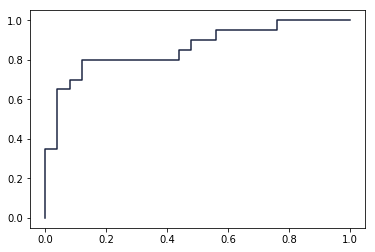

In [11]:
# Running a Naive Bayes Guassian Model:
# Guassian model because the predictors follow a Normal Distribution

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

# Training the model using the training data

model.fit(x_train, y_train)
train_predictions = model.predict(x_train)
predictions = model.predict(x_validation)

# Accuracy Metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Confusion Matrix Comparison
print("Confustion Matrix for Training Data - Logistic Regression")
print(confusion_matrix(y_train, train_predictions))
print("Confustion Matrix for Test Data - Logistic Regression")
print(confusion_matrix(y_validation, predictions))

# Classification Report Comparison
print("Classification Report for Training Data - Logistic Regression")
print(classification_report(y_train, train_predictions))
print("Classification Report for Test Data - Logistic Regression")
print(classification_report(y_validation, predictions))

proba_train_predictions = model.predict_proba(x_train)[:,1]
proba_predictions = model.predict_proba(x_validation)[:,1]
roc_auc_score(y_validation, proba_predictions, average='weighted')

# Print the log loss metric

print("Log loss for Training data: ", log_loss(y_train, proba_train_predictions))
print("Log loss for Validation data: ", log_loss(y_validation, proba_predictions))

fpr, tpr, threshold = roc_curve(y_validation, proba_predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("\nAUROC Plot from Guassian NB:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

In [12]:
# # Pushing the repo to git

# ! cd "C:\\Users\\sivac\\Documents\\Python Projects\\Driven Data\\Predicting Heart Disease"

# ! git add .
# ! git commit -am "Added new base file"
# ! git push